In [148]:
include("DenseNTK.jl")
include("FastNTK.jl")

function eig_fix(K)
    eigen_values = abs.(eigen(K).values)  # get eigenvalues of Kernel
    eigen_values_fixed = [val == 0 ? 1e-22 : val for val in eigen_values]  # add 10^-16 if eigenvalue is 0
    return eigen_values_fixed
end

Nθ(model) = sum(length, Flux.params(model)); # Calculate notal amount of params

In [2]:
Nx=300
a=-1.0; b=1.0

xVec=collect(range(a,stop=b,length=Nx));
yVec=sin.(2*pi*xVec) .+ 0.1*randn(size(xVec)); 

In [3]:
Nh = 1000
act = relu

model = Chain(DenseNTK(1,Nh,act),DenseNTK(Nh,1))

Chain(
  DenseNTK(Float32[-1.8868544; -0.20385312; … ; -0.4725773; -0.3458407;;], Float32[-0.4804666, -1.2239946, 0.1876509, 0.29929447, 1.0739383, -0.73303264, -0.41407898, 0.1652273, -0.25570074, 0.014999755  …  -0.13937764, 0.57622045, 0.3595211, -2.2316933, 2.1050193, 1.2775928, -0.5929233, -1.3981069, -0.56182104, 0.7435434], NNlib.relu),  # 2_000 parameters
  DenseNTK(Float32[-1.0305659 0.36836317 … 1.5951021 -1.1846321], Float32[0.3747966], identity),  # 1_001 parameters
)                   # Total: 4 arrays, 3_001 parameters, 12.020 KiB.

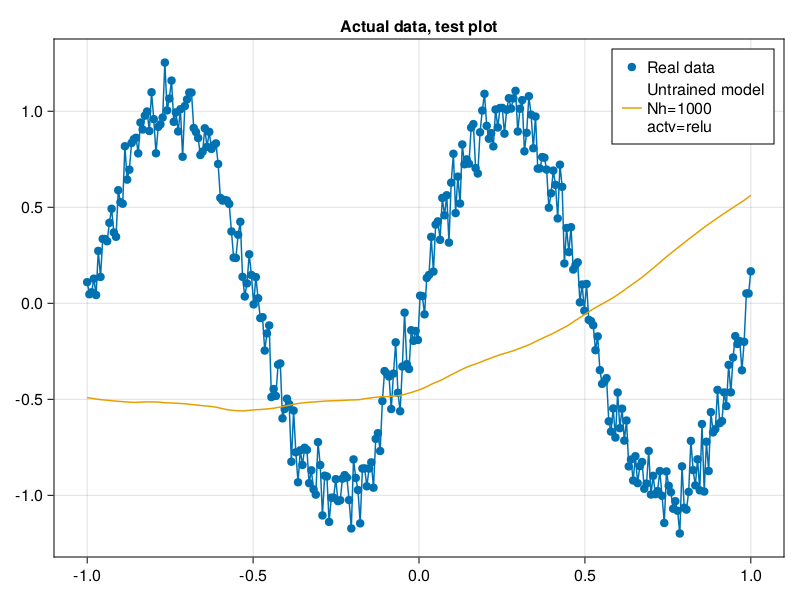

In [4]:
using CairoMakie

fig = Figure()
ax1 = Axis(fig[1,1],title="Actual data, test plot")

CairoMakie.lines!(xVec[:], yVec[:])
CairoMakie.scatter!(xVec[:], yVec[:], label="Real data")

CairoMakie.lines!(xVec[:], model(hcat(xVec...))[:], label="Untrained model\nNh=$Nh\nactv=$act")

axislegend(ax1,position=:rt)
fig

<h1>Trektin</h1>

In [143]:
using Distributions

a = -1.0;
b = 1.0;
Nx = 100
IN = 10

# Generate random matrix with numbers from a to b (inclusive)
xTrekt = rand(Uniform(-1,1),IN,Nx)

10×100 Matrix{Float64}:
 -0.0114774  -0.0981534   0.623878  …  -0.651512   0.196924   0.491771
  0.96446     0.307586   -0.193741     -0.528672  -0.908752  -0.0951965
 -0.555558    0.153672    0.195712      0.602288  -0.221822   0.584564
  0.313049    0.879868   -0.639413     -0.144041  -0.242937   0.857865
  0.419235    0.24267    -0.283847      0.755044   0.949563  -0.957724
 -0.93959    -0.69821     0.134223  …   0.246347  -0.711201   0.902452
  0.621065    0.485541    0.51238      -0.652498  -0.651147  -0.302078
  0.499115    0.81768    -0.254541     -0.530401   0.884467   0.560257
  0.590779    0.63517     0.369708     -0.802971   0.469725   0.0157165
 -0.984319   -0.528474    0.857105     -0.109529   0.225711   0.0525103

In [144]:
OUT = 3
ACT = relu

trekt1 = Chain(DenseNTK(IN, IN-Int(round((IN-OUT)/2)), ACT), DenseNTK(IN-Int(round((IN-OUT)/2)), OUT))

trekt3 = Chain(DenseNTK(IN, 8, ACT), DenseNTK(8,7, ACT), DenseNTK(7,5,ACT), DenseNTK(5,OUT));

trektÖll = Chain(DenseNTK(IN, IN-1, ACT))

for i in 0:(IN-OUT-2)
    trektÖll = Chain(trektÖll, DenseNTK(IN-1-i, IN-2-i, ACT))
end

In [145]:
K_trekt1 = kernel(trekt1, xTrekt,true);
K_trekt3 = kernel(trekt3, xTrekt,true);
K_trektÖll = kernel(trektÖll, xTrekt,true);

In [149]:
eig_trekt1 = eig_fix(K_trekt1);
eig_trekt3 = eig_fix(K_trekt3);
eig_trektÖll = eig_fix(K_trektÖll);

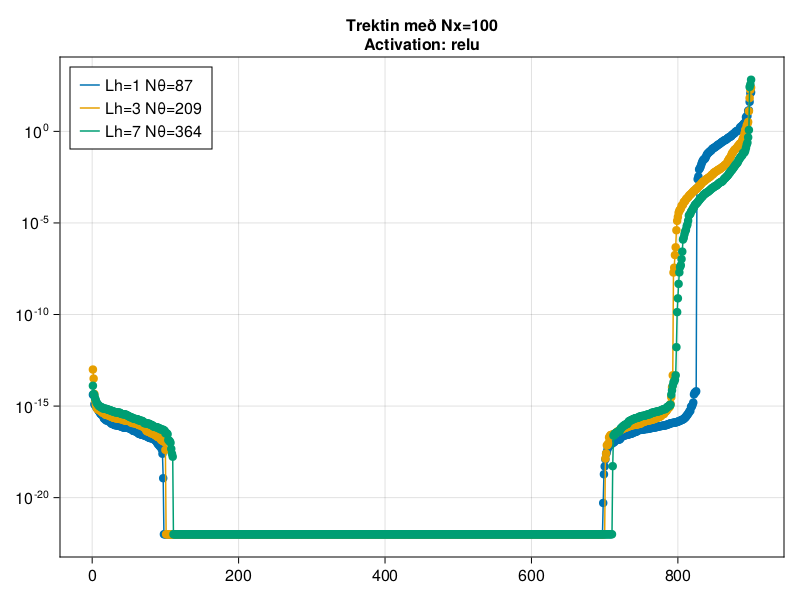

In [150]:
using CairoMakie

fig = Figure()
ax1 = Axis(fig[1,1], yscale=log10, title="Trektin með Nx=$Nx\nActivation: $ACT")

N1 = Nθ(trekt1)
N3 = Nθ(trekt3)
NÖll = Nθ(trektÖll)

CairoMakie.lines!(eig_trekt1, label="Lh=1 Nθ=$N1")
CairoMakie.scatter!(eig_trekt1)


CairoMakie.lines!(eig_trekt3, label="Lh=3 Nθ=$N3")
CairoMakie.scatter!(eig_trekt3)

CairoMakie.lines!(eig_trektÖll, label="Lh=$(IN-OUT) Nθ=$NÖll")
CairoMakie.scatter!(eig_trektÖll)


axislegend(ax1,position=:lt)
fig

<h1>Tímaglasið<h1>